# Predict `sales_price` on `taladrod` Dataset

In [10]:
# #install pythainlp 2.1
# !pip install --upgrade --pre pythainlp

In [2]:
import pandas as pd
import numpy as np
from plotnine import *
import qgrid

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#nlp stuff
from pythainlp.ulmfit import pre_rules_th_sparse, post_rules_th_sparse, process_thai
from pythainlp.tokenize import word_tokenize

#utility
import utils
import visualize

#stop warnings
import warnings
warnings.filterwarnings('ignore')

In [42]:
'''
Snippet for plotnine with Thai font by @korakot
https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
'''

from plotnine import *
import matplotlib.font_manager as fm

fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
theme_set(theme_gray(11, 'TH Sarabun New'))

In [3]:
df = pd.read_csv('data/taladrod/taladrod.csv')
df = utils.missingify(df)
print(df.shape)
qgrid.show_grid(df)

Index(['brand', 'series', 'gen', 'color', 'gear', 'gas', 'description',
       'contact_location', 'dow'],
      dtype='object')
(14037, 21)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# def show_desc(idx): print(df.description[idx])
# interact(show_desc, idx=widgets.Dropdown(options=list(df.index)))

In [6]:
#clean รหัสอ้างอิง
def clean_ref(x): return '\n'.join(x.split('\n')[:-1])
df['description'] = df.description.map(clean_ref)
# interact(show_desc, idx=widgets.Dropdown(options=list(df.index)))

In [7]:
pre_rules_th_sparse

[<function pythainlp.ulmfit.fix_html(x:str) -> str>,
 <function pythainlp.util.normalize.normalize(text:str) -> str>,
 <function pythainlp.ulmfit.spec_add_spaces(t:str) -> str>,
 <function pythainlp.ulmfit.rm_useless_spaces(t:str) -> str>,
 <function pythainlp.ulmfit.rm_useless_newlines(text:str) -> str>,
 <function pythainlp.ulmfit.rm_brackets(text:str) -> str>,
 <function pythainlp.ulmfit.replace_url(x)>,
 <function pythainlp.ulmfit.replace_rep_nonum(text:str) -> str>]

In [8]:
word_tokenize('เด็กเดินตากลม')

['เด็ก', 'เดิน', 'ตากลม']

In [9]:
post_rules_th_sparse

[<function pythainlp.ulmfit.ungroup_emoji(toks:Collection)>,
 <function pythainlp.ulmfit.lowercase_all(toks:Collection)>,
 <function pythainlp.ulmfit.replace_wrep_post_nonum(toks:Collection)>,
 <function pythainlp.ulmfit.remove_space(toks:Collection)>]

In [10]:
t='วันนี้ยยยยยยยยยยยยยไปกินกินกินกินกินกิน HELLO'
process_thai(t)

['วันนี้', 'ย', 'xxrep', 'ไป', 'xxwrep', 'กิน', 'hello']

In [11]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cnt = CountVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=3, max_df=0.9)
cnt_fit = cnt.fit(df.description)
cnt_mat = cnt_fit.transform(df.description)

#for exploration
cnt_mat_np = cnt_mat.toarray()
features = cnt_fit.get_feature_names()

In [12]:
visualize.top_feats_label(cnt_mat_np,features).head(10)

,feature,score,ngram
0,\n,1.380352,1
1,รถ,1.315808,1
2,สวย,0.910665,1
3,ได้,0.564508,1
4,พร้อม,0.532023,1
5,ดี,0.524827,1
6,ปี,0.524329,1
7,สภาพ,0.523046,1
8,-,0.501460,1
9,ๆ,0.416471,1


In [13]:
tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=3, sublinear_tf=True)
tfidf_fit = tfidf.fit(df.description)
tfidf_mat = tfidf_fit.transform(df.description)

#for exploration
tfidf_mat_np = tfidf_mat.toarray()
features = tfidf_fit.get_feature_names()

In [14]:
visualize.top_feats_label(tfidf_mat_np,features).head(10)

,feature,score,ngram
0,✅,0.008529,1
1,-,0.007684,1
2,",",0.006529,1
3,​,0.005315,1
4,บ.,0.005182,1
5,แต่ง,0.004059,1
6,เพียง,0.003823,1
7,เอง,0.003083,1
8,ขาย,0.003081,1
9,benz,0.002929,1


In [15]:
df.sales_price.describe()

count    1.403700e+04
mean     6.067932e+05
std      8.720579e+05
min      2.000000e+04
25%      2.790000e+05
50%      4.130000e+05
75%      6.480000e+05
max      5.500000e+07
Name: sales_price, dtype: float64

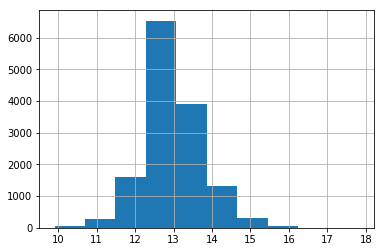

In [16]:
df.sales_price.map(np.log).hist()

In [17]:
df['quartile'] = pd.qcut(df['sales_price'], 4, labels=False)
df.quartile.value_counts()

0    3566
2    3514
3    3503
1    3454
Name: quartile, dtype: int64

In [18]:
df.groupby('quartile').sales_price.describe()

,count,mean,std,min,25%,50%,75%,max
quartile,,,,,,,,
0,3566.0,1.931573e+05,6.434247e+04,20000.0,148000.0,200000.0,249000.0,279000.0
1,3454.0,3.482707e+05,3.739802e+04,280000.0,318000.0,349000.0,380000.0,413000.0
2,3514.0,5.036605e+05,6.382972e+04,414000.0,449000.0,490000.0,550000.0,648000.0
3,3503.0,1.386231e+06,1.476425e+06,649000.0,759000.0,998000.0,1490000.0,55000000.0


In [19]:
ts = visualize.top_feats_all(tfidf_mat_np, df['quartile'],features)
print(ts[0].shape)
ts[0].head()

(35451, 5)


,rank,feature,score,ngram,label
0,0,​,0.007125,1,0
1,1,พร้อม ใช้,0.006280,2,0
2,2,✅,0.006208,1,0
3,3,ขาย,0.006097,1,0
4,4,-,0.005231,1,0


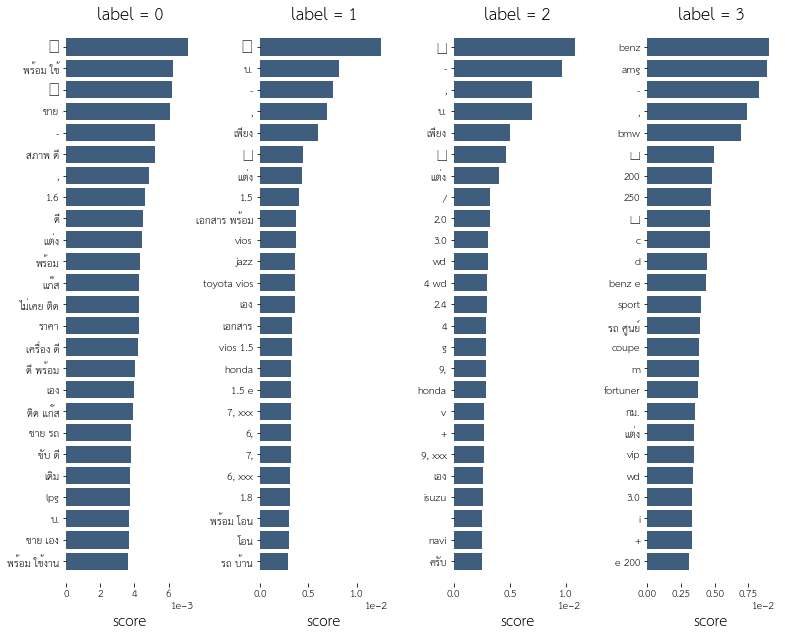

In [43]:
visualize.plot_top_feats(ts)

In [21]:
#modeling with everything we know so far
df = df[['sales_price', #dependent
         'description', #text
         'subscribers', #numerical
         'contact_location','brand','series','gen','year','color','gear' #categorical
        ]]

In [22]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=1412)
train_df.shape,valid_df.shape

((11229, 10), (2808, 10))

In [23]:
#dependent
import numpy as np
y_train, y_valid = np.array(train_df.sales_price), np.array(valid_df.sales_price)
y_train.shape,y_valid.shape

((11229,), (2808,))

In [24]:
#text
tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=5, sublinear_tf=True)
tfidf_fit = tfidf.fit(train_df.description) #fit with train only
features = tfidf_fit.get_feature_names()
text_train = tfidf_fit.transform(train_df.description)
text_valid = tfidf_fit.transform(valid_df.description)
text_train.shape,text_valid.shape

((11229, 18639), (2808, 18639))

In [25]:
#truncated svd
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
svd.fit(text_train)
trunc_train = svd.transform(text_train)
trunc_valid = svd.transform(text_valid)
trunc_train.shape, trunc_valid.shape

((11229, 100), (2808, 100))

In [26]:
#numerical
from sklearn.preprocessing import StandardScaler
med = train_df.subscribers.median()
num_train = np.array(train_df.subscribers.fillna(med))[:,None]
num_valid = np.array(valid_df.subscribers.fillna(med))[:,None]
ss = StandardScaler()
ss.fit(num_train)
norm_train = ss.transform(num_train)
norm_valid = ss.transform(num_valid)
norm_train.shape, norm_valid.shape

((11229, 1), (2808, 1))

In [27]:
#categorical
from sklearn.preprocessing import OneHotEncoder
cats = ['contact_location','brand','series','gen','year','color','gear']
utils.check_mode(df[cats])

,col,value,per_mode,nb_value
0,contact_location,กรุงเทพ,0.876042,3
1,gen,others,0.872052,4
2,gear,เกียร์ออโต้,0.801952,2
3,series,others,0.757569,7
4,brand,TOYOTA,0.301133,11
5,color,สีขาว,0.299708,6
6,year,2013,0.123246,40


In [28]:
interact(utils.value_dist, df=fixed(df[cats]), 
    col=widgets.Dropdown(options=cats))

interactive(children=(Dropdown(description='col', options=('contact_location', 'brand', 'series', 'gen', 'year…

<function utils.value_dist(df, col)>

In [29]:
ohe_df = pd.get_dummies(df[cats])
ohe_df.shape

(14037, 34)

In [30]:
ohe_train, ohe_valid = train_test_split(ohe_df,test_size=0.2,random_state=1412)
ohe_train,ohe_valid = np.array(ohe_train),np.array(ohe_valid)
ohe_train.shape, ohe_valid.shape

((11229, 34), (2808, 34))

In [31]:
#dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(ohe_train)
pca_train, pca_valid = pca.transform(ohe_train), pca.transform(ohe_valid)
pca_train.shape, pca_valid.shape

((11229, 30), (2808, 30))

In [32]:
pca_train[:,1].mean(), pca_valid[:,1].mean()

(2.644998339546904e-16, -0.0195087899129346)

In [33]:
pca_train[:,1].std(), pca_valid[:,1].std()

(0.6261969488603405, 0.618446987381426)

In [34]:
#concatenate
X_train = np.concatenate([trunc_train,norm_train,pca_train],1)
X_valid = np.concatenate([trunc_valid,norm_valid,pca_valid],1)
X_train.shape,X_valid.shape

((11229, 131), (2808, 131))

In [35]:
from sklearn.ensemble import RandomForestRegressor
learn = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=0.8,
                              min_samples_leaf=1)

In [36]:
#baseline
def mae(y_true,preds): return abs(preds-y_true).mean()
def mape(y_true,preds): return (abs(preds-y_true)/y_true).mean()

#mean
print(f'Predicting only mean: {mae(y_valid,y_train.mean())}')
#median
print(f'Predicting only median: {mae(y_valid,np.percentile(y_train,50))}')

Predicting only mean: 386987.79069457675
Predicting only median: 336537.7492877493


In [37]:
#with only texts
learn.fit(trunc_train,y_train)
preds = learn.predict(trunc_valid)
mae(y_valid,preds)

294198.6266079069

In [38]:
#with only numericals
learn.fit(norm_train,y_train)
preds = learn.predict(norm_valid)
mae(y_valid,preds)

248395.27454023802

In [39]:
#with only categoricals
learn.fit(pca_train,y_train)
preds = learn.predict(pca_valid)
mae(y_valid,preds)

249454.95704716572

In [40]:
#with everything
learn.fit(X_train,y_train)
preds = learn.predict(X_valid)
mae(y_valid,preds), mape(y_valid,preds)

(216791.7749463841, 0.515483894019414)

In [41]:
#std of y_valid
y_valid.std()

709891.2738672019